<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0822_keras%EB%B3%B5%EC%8A%B5/keras(%EB%B3%B4%EC%8A%A4%ED%84%B4_%EC%A3%BC%ED%83%9D%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%9A%8C%EA%B7%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 보스턴 주택데이터셋을 이용한 회귀
- 회귀는 분류와 다르게 손실함수로 평균 제곱 오차를 자주 사용합니다
- 회귀의 평가지표는 정확도는 적용되지 않으며, 평균 절대 오차를 자주 사용합니다
- 입력데이터의 피처가 너무 다른 범위를 가진다면 스케일 조정을 해야합니다
- 데이터가 적으면 K-겹 사용하는 것이 좋습니다

## 1.데이터셋 로드
- train_data 와 test_data : 범죄율, 지방세율 등
- train_labels 와 test_labels : 주택가격

In [31]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

###  1) 데이터 크기 확인


In [32]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [33]:
print(train_targets[:5])

[15.2 42.3 50.  21.1 17.7]


## 2.데이터 준비

### 1) 데이터 정규화
- 각 피처간의 데이터 스케일이 상이하므로 표준화를 통해 맞추어줍니다

In [34]:
# 평균 구하기
mean = train_data.mean(axis=0)
train_data -= mean

# 표준 편차 구하기
std = train_data.std(axis=0)
train_data /= std

test_data += mean
test_data /= std

## 3.모델 구성
- 회귀모델은 연속된 값을 예측하므로 회귀모델의 출력층엔 1개의 은닉유닛을 설정해야합니다.
- mse는 회귀문제에서 자주 사용되는 손실함수입니다.

In [35]:
from keras import models 
from keras import layers

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 검증하기
- 검증 점수는 4개의 폴드평균이 2.4임

In [47]:
import numpy as np

k=4

# 25개 * 4등분
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 # ', i)

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 피처 할당
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0
    )
    # 훈련 타겟 할당
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0
    )
    # 모델 구성
    model = build_model()
    # 모델 훈련
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 #  0
처리중인 폴드 #  1
처리중인 폴드 #  2
처리중인 폴드 #  3


In [49]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## epochs에 따른 MAE값 변화 그래프그리기

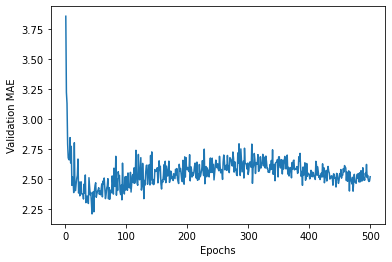

In [51]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 다시 그리기
- 지수 이동 평균을 이용하여 부드러운 곡선 얻기
- epochs 80이후로는 mae가 줄어들지 않음 => 과적합

In [ ]:
test = np.arange(1,100)
test[-1]

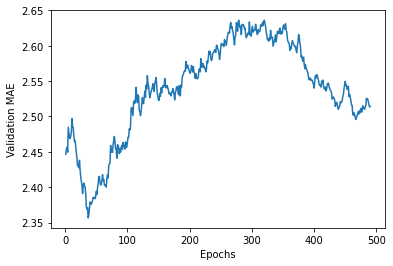

In [53]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else : 
            smoothed_points.append(point)
    return smoothed_points

# 앞의 10이후부터 곡선을 그린다
smooth_mae_history = smooth_curve(avg_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 최대 적합의 epochs로 다시 훈련

In [61]:
model = build_model()
model.fit(train_data, train_targets, epochs=30, batch_size=1, verbose=0)
# 손실과 검증결과 출력
# 손실 : mse, 검증방법 : mae
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 8681.2656 - mae: 92.9136
